In [1]:
from transformers import AutoModelWithLMHead, AutoTokenizer,VisionEncoderDecoderModel, ViTFeatureExtractor,ViTImageProcessor
import torch
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import random

In [2]:
from transformers import ViTModel, GPT2LMHeadModel

In [3]:
from torch import nn

In [4]:
import cv2
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

## 0. Functions

In [5]:
max_length = 100
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

def predict_step(image_paths):
    images = []
    for image_path in image_paths:

        try:
            i_image = Image.open(image_path)
        except:
            return None
            
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")
    
        images.append(i_image)
    
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    print(pixel_values.shape)
    pixel_values = pixel_values.to(device)
    
    output_ids = model.generate(pixel_values, **gen_kwargs)

    print(output_ids)
    
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    
    return preds

## 1. Load baseline model + basic performance check

In [6]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [7]:
for name, child in model.named_children():
        for x, y in child.named_children():
            print(name,x)

encoder embeddings
encoder encoder
encoder layernorm
encoder pooler
decoder transformer
decoder lm_head


In [8]:
model.encoder

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [9]:
model.decoder

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (crossattention): GPT2Attention(
          (c_attn): Conv1D()
          (q_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_cross_attn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation(

In [10]:
tokenizer

GPT2TokenizerFast(name_or_path='nlpconnect/vit-gpt2-image-captioning', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

## 2. Load VIST images

    Loading is slightly different from the previous notebook, as the entire set of images for one story together

## Train

In [11]:
ann = os.listdir("/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/annotations")
labels = open("/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/annotations/StoriesFin.json")
labels = json.load(labels)
labels["16"]

{'sent_ids': ['80', '81', '82', '83', '84'],
 'img_ids': ['181647714', '181626113', '181645575', '181635518', '181640606'],
 'album_id': '72157594187037689',
 'text': ['we took a nice hike into the forest today .',
  'we were lucky enough to see some wildlife , like this deer .',
  'this guy was friendly . he must hit up all the hikers for food .',
  "i 'm glad we spotted this snake before we got too close !",
  'the end of our hike rewarded us with an amazing view of the falls !']}

In [12]:
len(labels.keys())

5149

In [13]:
labels['16']

{'sent_ids': ['80', '81', '82', '83', '84'],
 'img_ids': ['181647714', '181626113', '181645575', '181635518', '181640606'],
 'album_id': '72157594187037689',
 'text': ['we took a nice hike into the forest today .',
  'we were lucky enough to see some wildlife , like this deer .',
  'this guy was friendly . he must hit up all the hikers for food .',
  "i 'm glad we spotted this snake before we got too close !",
  'the end of our hike rewarded us with an amazing view of the falls !']}

In [14]:
# stories = random.sample(list(labels.keys()),100) # choose 100 random stories

In [15]:
labels['16']

{'sent_ids': ['80', '81', '82', '83', '84'],
 'img_ids': ['181647714', '181626113', '181645575', '181635518', '181640606'],
 'album_id': '72157594187037689',
 'text': ['we took a nice hike into the forest today .',
  'we were lucky enough to see some wildlife , like this deer .',
  'this guy was friendly . he must hit up all the hikers for food .',
  "i 'm glad we spotted this snake before we got too close !",
  'the end of our hike rewarded us with an amazing view of the falls !']}

In [16]:
train = {}
for s in labels:
    for idx, im in enumerate(labels[s]['img_ids']):
        image_path = f"/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/{im}.jpeg"
        key = f"story_{s}"
        if key not in train:
            train[key] = {}
        train[key][idx] = {}
        train[key][idx]['image_path'] = image_path
        train[key][idx]['text'] = labels[s]['text'][idx]

    # train[s] = {}
    # train[s]["image_paths"] = []
    # train[s]["img_ids"] = labels[s]['img_ids']
    # train[s]["text"] = labels[s]['text']    
    # for im in train[s]["img_ids"]:
    #     train[s]["image_paths"].append(f"/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/{im}.jpeg")

In [17]:
train['story_16']

{0: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181647714.jpeg',
  'text': 'we took a nice hike into the forest today .'},
 1: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181626113.jpeg',
  'text': 'we were lucky enough to see some wildlife , like this deer .'},
 2: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181645575.jpeg',
  'text': 'this guy was friendly . he must hit up all the hikers for food .'},
 3: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181635518.jpeg',
  'text': "i 'm glad we spotted this snake before we got too close !"},
 4: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181640606.jpeg',
  'text': 'the end of our hike rewarded us with an amazing view of the falls !'}}

In [18]:
len(train.keys())

5149

In [19]:
print(list(train.keys())[2])
train[list(train.keys())[2]]

story_19


{0: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181647714.jpeg',
  'text': 'giant sequoia tree and red woods in the forest .'},
 1: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181626113.jpeg',
  'text': 'a young deer scampers about in the woods .'},
 2: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181645575.jpeg',
  'text': 'grey squirrel holding some food with his paws .'},
 3: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181635518.jpeg',
  'text': 'the snake slithers quietly through the underbrush .'},
 4: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181640606.jpeg',
  'text': 'beautiful picture taken of a river running through the valley .'}}

In [20]:
os.path.exists('/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181640606.jpeg')

True

# 2. Fine-tune on the VIST dataset

    Actually, I think we do not need to fine-tune the feature extractor.
    Just fine-tune the decoder based on the features produced by the extractor <<


    SOMEHOW have the dataloader load 5 images (so it's 5 x 3 x H x W)

    

In [21]:
class CustomImageDataset(Dataset):
    
    def __init__(self, stories_annotations, img_dir=None, transform=None, target_transform=None):
        # self.img_labels = annotations_file
        # self.img_dir = img_dir
        self.stories = stories_annotations
        self.stories_keys = list(stories_annotations.keys())
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        """Returns the number of samples in our dataset
        """
        return len(list(self.stories.keys()))

    def __getitem__(self, idx):

        if idx >= self.__len__():
            return
        story_num = self.stories_keys[idx]
        
        # get label
        # label = self.stories[story_num]['text']
        # label = tokenizer(label, padding="max_length").input_ids # omitted max_target_lengths
        # label = torch.tensor(label).squeeze()
        inputs = {}
        imgs = []
        labs = []
        atts = []
        print(f"getting {story_num}...")

        try:
            prev_img = None
            
            for seq in self.stories[story_num]:
                img_source = self.stories[story_num][seq]['image_path']
                img = read_image(img_source)
                img = feature_extractor(images=img, return_tensors="pt").pixel_values.squeeze()
                imgs.append(img.clone().detach())
                
                lab_source = self.stories[story_num][seq]['text']
                
                tok_out = tokenizer(lab_source, padding="max_length")
                lab = tok_out.input_ids
                lab = torch.tensor(lab).squeeze()
                labs.append(lab.clone().detach())

                att = tok_out.attention_mask
                att = torch.tensor(att).squeeze()
                atts.append(att.clone().detach())

                
            inputs['pixel_values'] = torch.stack(imgs)
            inputs['labels'] = torch.stack(labs)
            inputs['attention_mask'] = torch.stack(atts)
            
        except:
            return self.__getitem__(idx+1)
        
        return inputs

In [24]:
print(len(train))

5149


In [25]:
train_idx = random.sample(list(train.keys()), 1000)

In [26]:
train_fin = {}
for k in train_idx:
    train_fin[k] = train[k]

In [27]:
len(train_fin.keys())

1000

In [28]:
print(train['story_11678'][0]['text'] + ' ' + train['story_11678'][1]['text'])
print(tokenizer(train['story_11678'][0]['text'] + ' ' + train['story_11678'][1]['text']))

here is my sister and her all girl band performing for cash . my sister dress in her attire .
{'input_ids': [1456, 318, 616, 6621, 290, 607, 477, 2576, 4097, 9489, 329, 5003, 764, 616, 6621, 6576, 287, 607, 37629, 764], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [29]:
custom_train_data = CustomImageDataset(train_fin)
train_dataloader = DataLoader(custom_train_data, batch_size=1, shuffle=True) # , collate_fn=my_collate

In [30]:
output = next(iter(train_dataloader))
print(output['pixel_values'].shape)
print(output['labels'].shape)

getting story_35949...
getting story_36421...
torch.Size([1, 5, 3, 224, 224])
torch.Size([1, 5, 1024])


In [31]:
print(output['attention_mask'].shape)

torch.Size([1, 5, 1024])


In [32]:
# checking if attention mask working properly
print(sum(output['attention_mask'][0][0]))
len([i for i in output['labels'][0][0] if i != 50256])

tensor(8)


8

## (KEY PART OF THIS NOTEBOOK)Try to do generation!

### Check if I can feed in encoder output directly

In [56]:
img1 = read_image(train['story_16'][0]['image_path'])
img2 = read_image(train['story_16'][1]['image_path'])
img3 = read_image(train['story_16'][2]['image_path'])
img4 = read_image(train['story_16'][3]['image_path'])
img5 = read_image(train['story_16'][4]['image_path'])

In [57]:
lab1 = train['story_16'][0]['text']
lab2 = train['story_16'][1]['text']
lab3 = train['story_16'][2]['text']
lab4 = train['story_16'][3]['text']
lab5 = train['story_16'][4]['text']

Text(0.5, 1.0, 'we took a nice hike into the forest today .')

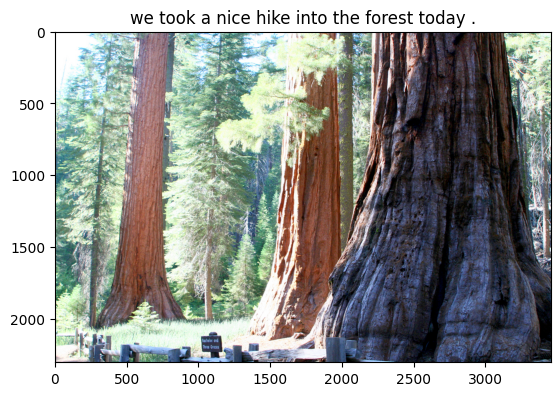

In [59]:
newimg1 = torch.swapaxes(img1, 0,2)
newimg1 = torch.swapaxes(newimg1, 0,1)
plt.imshow(np.array(newimg1))
plt.title(lab1)

Text(0.5, 1.0, 'we were lucky enough to see some wildlife , like this deer .')

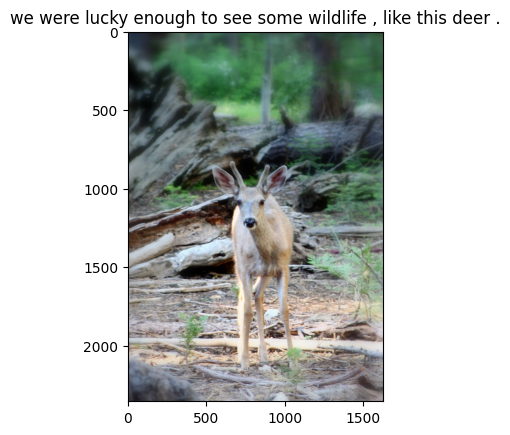

In [60]:
newimg2 = torch.swapaxes(img2, 0,2)
newimg2 = torch.swapaxes(newimg2, 0,1)
plt.imshow(np.array(newimg2))
plt.title(lab2)


Text(0.5, 1.0, 'this guy was friendly . he must hit up all the hikers for food .')

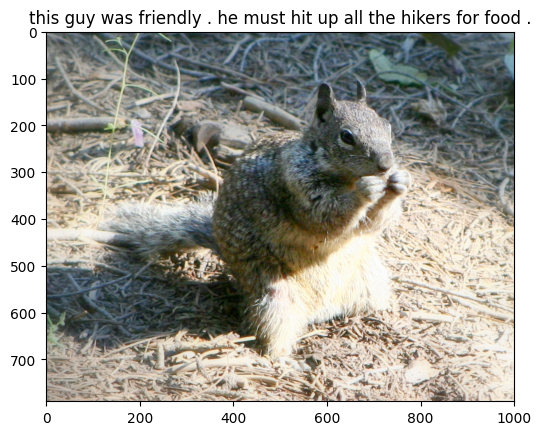

In [61]:
newimg3 = torch.swapaxes(img3, 0,2)
newimg3 = torch.swapaxes(newimg3, 0,1)
plt.imshow(np.array(newimg3))
plt.title(lab3)



Text(0.5, 1.0, "i 'm glad we spotted this snake before we got too close !")

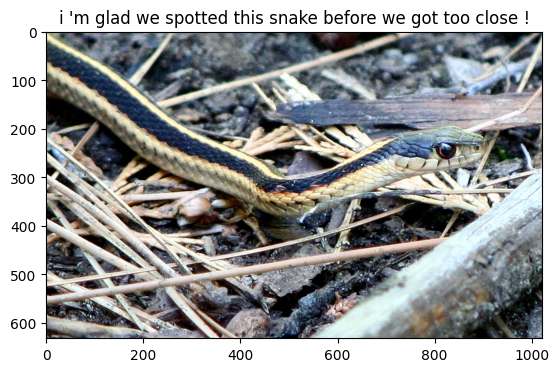

In [62]:
newimg4 = torch.swapaxes(img4, 0,2)
newimg4 = torch.swapaxes(newimg4, 0,1)
plt.imshow(np.array(newimg4))
plt.title(lab4)

Text(0.5, 1.0, 'the end of our hike rewarded us with an amazing view of the falls !')

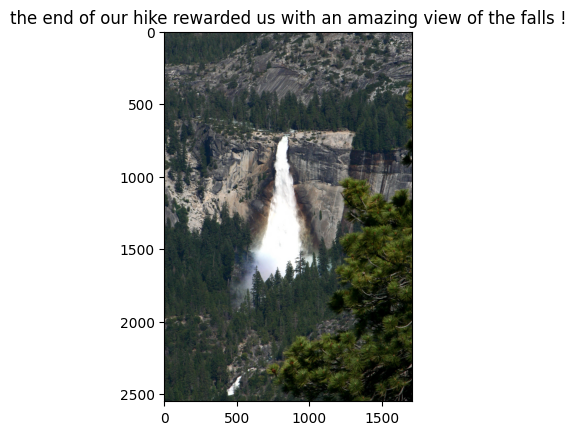

In [63]:
newimg5 = torch.swapaxes(img5, 0,2)
newimg5 = torch.swapaxes(newimg5, 0,1)
plt.imshow(np.array(newimg5))
plt.title(lab5)



In [64]:

img1_f = feature_extractor(images=img1, return_tensors="pt").pixel_values.squeeze()
img2_f = feature_extractor(images=img2, return_tensors="pt").pixel_values.squeeze()
img3_f = feature_extractor(images=img3, return_tensors="pt").pixel_values.squeeze()
img4_f = feature_extractor(images=img4, return_tensors="pt").pixel_values.squeeze()
img5_f = feature_extractor(images=img5, return_tensors="pt").pixel_values.squeeze()

imgs = [img1_f, img2_f, img3_f,img4_f,img5_f]

tok_out = tokenizer(lab1, padding="max_length")
lab1_id = tok_out.input_ids
lab1_id = torch.tensor(lab1_id).squeeze()

tok_out = tokenizer(lab2, padding="max_length")
lab2_id = tok_out.input_ids
lab2_id = torch.tensor(lab2_id).squeeze()

tok_out = tokenizer(lab3, padding="max_length")
lab3_id = tok_out.input_ids
lab3_id = torch.tensor(lab3_id).squeeze()

tok_out = tokenizer(lab4, padding="max_length")
lab4_id = tok_out.input_ids
lab4_id = torch.tensor(lab4_id).squeeze()

tok_out = tokenizer(lab5, padding="max_length")
lab5_id = tok_out.input_ids
lab5_id = torch.tensor(lab5_id).squeeze()

labs = [lab1_id, lab2_id, lab3_id, lab4_id, lab5_id]

In [65]:
pix1 = imgs[0].unsqueeze(0)
pix2 = imgs[1].unsqueeze(0)
pix3 = imgs[2].unsqueeze(0)
pix4 = imgs[3].unsqueeze(0)
pix5 = imgs[4].unsqueeze(0)

In [66]:
enc_out1 = model.encoder(pix1)
enc_out2 = model.encoder(pix2)
enc_out3 = model.encoder(pix3)
enc_out4 = model.encoder(pix4)
enc_out5 = model.encoder(pix5)

In [67]:
e1_h = enc_out1.last_hidden_state
e2_h = enc_out2.last_hidden_state
e3_h = enc_out3.last_hidden_state
e4_h = enc_out4.last_hidden_state
e5_h = enc_out5.last_hidden_state

enc_out1.last_hidden_state = torch.concat((e1_h, e1_h),1)
enc_out2.last_hidden_state = torch.concat((e1_h, e2_h),1)
enc_out3.last_hidden_state = torch.concat((e2_h, e3_h),1)
enc_out4.last_hidden_state = torch.concat((e3_h, e4_h),1)
enc_out5.last_hidden_state = torch.concat((e4_h, e5_h),1)

In [68]:
org_out1 = model.encoder(pix1)
org_out2 = model.encoder(pix2)
org_out3 = model.encoder(pix3)
org_out4 = model.encoder(pix4)
org_out5 = model.encoder(pix5)

In [69]:
# concatenated version

sam_outputids1 = model.generate(encoder_outputs=enc_out1,  **gen_kwargs)
sam_outputids2 = model.generate(encoder_outputs=enc_out2,  **gen_kwargs)
sam_outputids3 = model.generate(encoder_outputs=enc_out3,  **gen_kwargs)
sam_outputids4 = model.generate(encoder_outputs=enc_out4,  **gen_kwargs)
sam_outputids5 = model.generate(encoder_outputs=enc_out5,  **gen_kwargs)

In [70]:
# original version

org_outputids1 = model.generate(encoder_outputs=org_out1, **gen_kwargs)
org_outputids2 = model.generate(encoder_outputs=org_out2, **gen_kwargs)
org_outputids3 = model.generate(encoder_outputs=org_out3, **gen_kwargs)
org_outputids4 = model.generate(encoder_outputs=org_out4, **gen_kwargs)
org_outputids5 = model.generate(encoder_outputs=org_out5, **gen_kwargs)

In [73]:
print(tokenizer.batch_decode(sam_outputids1))
print(tokenizer.batch_decode(sam_outputids2))
print(tokenizer.batch_decode(sam_outputids3))
print(tokenizer.batch_decode(sam_outputids4))
print(tokenizer.batch_decode(sam_outputids5))

['<|endoftext|>a wooded area with a tree and some trees <|endoftext|>']
['<|endoftext|>a small animal standing in the middle of a forest <|endoftext|>']
['<|endoftext|>a small brown and white animal standing in a field <|endoftext|>']
['<|endoftext|>a black and white photo of a brown and white animal <|endoftext|>']
['<|endoftext|>a bird is standing in the middle of a stream <|endoftext|>']


In [72]:
print(tokenizer.batch_decode(org_outputids1))
print(tokenizer.batch_decode(org_outputids2))
print(tokenizer.batch_decode(org_outputids3))
print(tokenizer.batch_decode(org_outputids4))
print(tokenizer.batch_decode(org_outputids5))

['<|endoftext|>a wooded area with a tree and some trees <|endoftext|>']
['<|endoftext|>a brown and white animal standing on top of a dirt field <|endoftext|>']
['<|endoftext|>a black and white photo of a brown and white animal <|endoftext|>']
['<|endoftext|>a small orange and white bird is standing on the ground <|endoftext|>']
['<|endoftext|>a river flowing through a forest filled with boulders <|endoftext|>']
